In [1]:
import json
import argparse
import numpy as np
import pandas as pd
import seaborn as sns
from datasets import load_dataset, Dataset, load_from_disk
import matplotlib.pyplot as plt 
from transformers import AutoTokenizer

/home/yilong/miniconda3/envs/vllm/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_parquet('../data/train/ToM_train_600.parquet')

In [3]:
len(df)

600

In [4]:
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-0.5B-Instruct", trust_remote_code=True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   story_structure     600 non-null    object
 1   infilled_story      600 non-null    object
 2   question            600 non-null    object
 3   answer              600 non-null    object
 4   question_type       600 non-null    object
 5   params              600 non-null    object
 6   nth_order           600 non-null    int64 
 7   is_interesting      600 non-null    bool  
 8   story_type          600 non-null    object
 9   story_structure_wn  600 non-null    object
dtypes: bool(1), int64(1), object(8)
memory usage: 42.9+ KB


In [8]:
df.groupby(['story_type']).params.count()

story_type
all                              45
all+asymmetric                   27
allbutfantom                     43
allbutfantom+asymmetric          58
tomi                             76
tomi+asymmetric                  30
tomi+info-exchange               45
tomi+info-exchange+asymmetric    61
tomi+object-state                62
tomi+object-state+asymmetric     52
tomi+room-changes                36
tomi+room-changes+asymmetric     60
tomi-object-state                 4
tomi-object-state+asymmetric      1
Name: params, dtype: int64

In [9]:
df.groupby(['is_interesting','nth_order']).story_structure.count()

is_interesting  nth_order
False            1            12
                 2            68
True            -1           181
                 1           133
                 2           206
Name: story_structure, dtype: int64

In [14]:
dfs = df.groupby(['story_structure']).answer.count().reset_index()

In [26]:
len(dfs)

177

In [25]:
len(df.groupby(['infilled_story']).answer.count().reset_index())

177

In [16]:
dfs.answer.max()

18

In [38]:
df_grouped_ = df.groupby("story_structure", as_index=False).agg({"question": list,"answer": list, "infilled_story": "first", 'story_structure_wn':'first', 'params':'count'})
df_grouped = df_grouped_.reset_index()

In [39]:
df_grouped.groupby('params').answer.count()

params
1     63
2     39
3     22
4     16
5      7
6      4
7      5
8      8
9      1
10     2
11     4
15     1
16     3
17     1
18     1
Name: answer, dtype: int64

In [45]:
dft = df_grouped.loc[df_grouped.params<7].copy()
dft.index = range(len(dft))

In [152]:
SYSTEM_PROMPT = """You are a helpful assistant. First, think through the question internally before providing the final answer. The reasoning process and answer are enclosed within <think> </think> and <answer> </answer> tags, respectively, i.e., <think> step by step reasoning here </think><answer> answer here </answer>. For multiple questions, clearly answer each one sequentially, e.g., <answer>(1) answer 1 (2) answer 2 </answer>"""

In [153]:
XML_COT_FORMAT = """Story: {}\n Question:{}"""

In [154]:
dft.columns

Index(['index', 'story_structure', 'question', 'answer', 'infilled_story',
       'story_structure_wn', 'params'],
      dtype='object')

In [155]:
dfm = dft.melt(id_vars=['question', 'answer'], value_vars=['infilled_story', 'story_structure', 'story_structure_wn'], var_name='story_group',value_name='story')

In [156]:
def get_prompts(dft):
    prompt = []
    for i in range(len(dft)):
        if type(dft['answer'][i]) == str:
            ans = eval(dft['answer'][i])
        else:
            ans = dft['answer'][i]
        if len(ans)==1:
            prompt.append( [
                    {'role': 'system', 'content': SYSTEM_PROMPT},
                    {'role': 'user', 'content': XML_COT_FORMAT.format(dft['story'][i], dft['question'][i][0])}
                ])
        else:
            content = """Story: {}""".format(dft['story'][i])
            for k, q in enumerate(dft['question'][i]):
                content+='\nQuestion {}: {}'.format(k+1, q)
            prompt.append( [
                    {'role': 'system', 'content': SYSTEM_PROMPT},
                    {'role': 'user', 'content': content}
                ])
    return prompt

In [157]:
prompts = get_prompts(dfm)

In [158]:
print(prompts[2][1]['content'])

Story: The dimly lit waiting lounge was quiet, with only the soft hum of the ventilation system and the occasional tick of the wall clock breaking the stillness. A metal file cabinet stood against one wall, while a few scattered chairs were arranged around a low coffee table, creating a sense of calm before a gathering storm. As Abigail entered the waiting lounge, the calm ambiance seemed almost palpable, with the faint hum of the ventilation system and the clock's gentle tick-tock providing a soothing background melody. Her gaze scanned the room, taking in the neatly arranged chairs and the metal file cabinet against the wall. In a hushed conversation with Jasmine, Abigail's soft voice came through, the words clear even if the context was discreetly veiled, as she whispered, "I'm taking care of things in the waiting lounge now." With a quiet sense of purpose, Abigail placed the silver letter opener in the metal file cabinet, its new home within the waiting lounge a reflection of her o

In [159]:
dfm['prompt'] = prompts

In [160]:
import re

def extract_ordered_answers(text, correct_answers):
    """
    按照指定顺序从文本中提取正确答案
    
    Args:
        text (str): 输入文本
        correct_answers (list): 预期正确答案的列表（按顺序）
    
    Returns:
        list: 解析出的答案列表，按正确答案的顺序排列
    """
    # 按“。；\n”分割文本为句子列表
    sentences = re.split(r"[。；;.\n]", text)
    
    extracted_answers = []
    last_matched_index = -1  # 记录上一次匹配成功的索引，确保匹配顺序
    
    for correct_ai in correct_answers:
        pattern = r"\b(?:in|at|on|inside)?\s*(?:the\s*)?" + re.escape(correct_ai) + r"\b"

        # 只从上一次匹配成功的位置往后搜索
        for i in range(last_matched_index + 1, len(sentences)):
            if re.search(pattern, sentences[i], re.IGNORECASE):
                extracted_answers.append(correct_ai)
                last_matched_index = i  # 记录匹配成功的索引
                break  # 只允许匹配一次，防止重复使用同一部分文本
        
    return extracted_answers

In [161]:
extract_ordered_answers('(1) leather satchel . waiting lounge. (1) ', ['waiting lounge', 'waiting lounge', 'waiting lounge', 'conference room'])

['waiting lounge']

In [162]:
data = Dataset.from_pandas(dfm)

In [163]:
len(data['prompt'])

453

<Axes: ylabel='Count'>

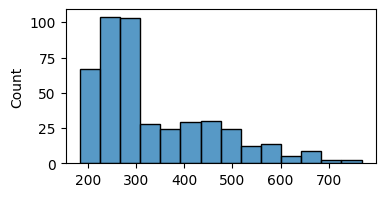

In [164]:
token_lengths = []
for prompt_list in data['prompt']:
    # Each prompt is a list of dictionaries, we want the 'content' of the first dict
    # Tokenize the content
    tokens = tokenizer.apply_chat_template(prompt_list)
    token_lengths.append(len(tokens))

token_lengths = np.array(token_lengths)
_, ax = plt.subplots(1, 1, figsize=(4, 2))
sns.histplot(token_lengths)

In [165]:
df_train_ = dfm.iloc[np.arange(len(token_lengths))[token_lengths<512]]
df_train_.index = range(len(df_train_))

In [166]:
data_train = Dataset.from_pandas(df_train_)

In [167]:
data_train

Dataset({
    features: ['question', 'answer', 'story_group', 'story', 'prompt'],
    num_rows: 405
})

In [168]:
data_train.to_parquet('../data/train/ToM_train_multiquestion.parquet')

Creating parquet from Arrow format: 100%|██████████| 1/1 [00:00<00:00, 485.68ba/s]


992696

In [144]:
def extract_xml_answer(text: str) -> str:
    answer_pattern = r'<answer>(.*?)</answer>'
    matches = list(re.finditer(answer_pattern, text, re.DOTALL))
    if not matches:
        return None
        
    final_answer = matches[-1].group(1).strip()
    return final_answer



def normalize_answer(answer: str) -> str:
    """Normalizes the answer text for better comparison.
    Args:
        answer: Raw answer text
    Returns:
        Normalized answer text
    """
    # Convert to lowercase
    normalized = answer.lower()
    # Remove extra whitespace
    normalized = re.sub(r'\s+', ' ', normalized).strip()
    # Remove punctuation that doesn't affect meaning
    normalized = re.sub(r'[.,;:!?]', '', normalized)
    return normalized


def extract_ordered_answers(text, correct_answers):
    """
    按照指定顺序从文本中提取正确答案
    
    Args:
        text (str): 输入文本
        correct_answers (list): 预期正确答案的列表（按顺序）
    
    Returns:
        list: 解析出的答案列表，按正确答案的顺序排列
    """
    # 按“。；\n”分割文本为句子列表
    sentences = re.split(r"[。；;.\n]", text)
    sentences = [normalize_answer(s) for s in sentences]
    extracted_answers = []
    last_matched_index = -1  # 记录上一次匹配成功的索引，确保匹配顺序
    
    for correct_ai in correct_answers:
        pattern = r"\b(?:in|at|on|inside)?\s*(?:the\s*)?" + re.escape(correct_ai) + r"\b"

        # 只从上一次匹配成功的位置往后搜索
        for i in range(last_matched_index + 1, len(sentences)):
            if re.search(pattern, sentences[i], re.IGNORECASE):
                extracted_answers.append(correct_ai)
                last_matched_index = i  # 记录匹配成功的索引
                break  # 只允许匹配一次，防止重复使用同一部分文本
    return extracted_answers


def reward_func_(response, answer):
    pattern = r"^<think>.*?</think>\s*<answer>.*?</answer>$"
    match = re.match(pattern, response, re.DOTALL | re.MULTILINE)

    if match:
        response_ = extract_xml_answer(response)
        if response_ is None:
            return 0.5
        norm_response = response_
        norm_answer = [normalize_answer(each) for each in answer] 
        pred_status = extract_ordered_answers(norm_response, norm_answer)
        print(pred_status, norm_answer)
        if pred_status == norm_answer:
            return 2
        else:
            return 0.5 + 0.05*len(pred_status)
    else:
        return 0

In [145]:
data_train['answer'][2]

['airport terminal gate area', 'briefcase']

In [146]:
print(data_train['story'][2])

In the bustling airport terminal, the bright fluorescent lights overhead illuminated rows of neatly lined seats, while sleek laptops and smartphones hummed quietly on laps and in hands. The constant murmur of distant conversations and the occasional jet taking off created a soothing background noise, setting the scene for another ordinary day of travel and transit. Through the throngs of people at the gate, Alexander expertly navigated, juggling his numerous belongings and precious little spare time, with each carefully calculated move a testament to his experience as a seasoned traveler. He passed unobtrusively by Dominic, a man moving against the tide of weary travelers, and an uncanny air of alertness surrounded him. With economical movements, Alexander had stowed his travel documents and belongings in remarkably little time. Opening the briefcase just long enough to pull out the leather wallet, he deposited it into a safer location - his backpack, which he zipped up firmly after a 

In [147]:
answer = "<think>think</think><answer>'airport terminal gate area'\n (2) at the briefcase.</answer>"
answer_wrong = "<think>think</think><answer>(2) at the  . 'airport terminal  area'\n </answer>"
answer_p1 = "<think>think</think><answer>'airport terminal gate area.</answer>"
answer_p2 = "<think>think</think><answer>'airport terminal gate. briefcase</answer>"

In [148]:
reward_func_(answer, data_train['answer'][2])

['airport terminal gate area', 'briefcase'] ['airport terminal gate area', 'briefcase']


2

In [149]:
reward_func_(answer_wrong, data_train['answer'][2])

[] ['airport terminal gate area', 'briefcase']


0.5

In [150]:
reward_func_(answer_p1, data_train['answer'][2])

['airport terminal gate area'] ['airport terminal gate area', 'briefcase']


0.55

In [151]:
reward_func_(answer_p2, data_train['answer'][2])

['briefcase'] ['airport terminal gate area', 'briefcase']


0.55

In [173]:
print(np.unique(df.answer))

['airport terminal gate area' 'arrangement room' 'art studio'
 'back office' 'back office of the vet shop'
 'back room of the coffee shop' 'back room of the game store'
 'back room of the pub' 'back room of the thrift store' 'backpack'
 'backstage lounge' 'backstage production office' 'backstage tent'
 'ballroom' 'black leather wallet' 'black plastic storage bin' 'briefcase'
 'briefing room' 'canvas backpack' 'canvas bag' 'canvas duffel bag'
 'canvas tote bag' 'cardboard box' 'cardboard envelope'
 'cardboard evidence box' 'cardboard file box' 'cardboard storage box'
 'cemetery maintenance office' 'chapel' 'collaborative study room'
 'community room' 'conference room' 'conservation lab'
 'consulate meeting room' 'consulate reception area' 'consultation room'
 'control room' 'crew lounge' 'desk drawer' "diner's back room"
 'employee break room' 'evidence storage room' 'fabric pouch'
 'festival merchandise booth' 'galley' 'grand ballroom' 'green room'
 'guitar case' 'hospital conference r